# Nireports

Nireports is a framework to easily combine what we call reportlets, that is data visualizations that help assess the quality of a particular processing step, into HTML visual report. In this notebook, we give you an example about how to build your own visual report using the nireports framework. The goal with this example visual report is to summarize some group properties of functional connectivity (FC) matrices computed from a single dataset in order to assess the quality of connectivity extraction.


In [7]:
# Silence warnings
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

# Load data
import glob
import os

import pandas as pd
import numpy as np
import os.path as op

# Define the path where the derivatives are stored
output = "./data"

# Load fMRI duration after censoring
good_timepoints_df = pd.read_csv(op.join(output, "fMRI_duration_after_censoring.csv"))

# Load functional connectivity matrices
fc_matrices = []
connectivity_files = glob.glob(op.join(output, '**', '*connectivity.tsv'), recursive=True)
for idx, connectivity_file in enumerate(connectivity_files):
    fc_matrix = np.loadtxt(connectivity_file, delimiter="\t")
    flattened = fc_matrix.reshape(-1)
    session = [f"Session {idx+1}"] * len(flattened)
    fc_matrices.extend(zip(flattened, session))

# Create folder to store reportlets
os.makedirs(op.join(output, "reportlets"), exist_ok=True)

## Reportlets

The first step is to generate the visualizations you would like and store them in a file with a BIDS-compatible name. The reportlets filename need to be BIDS compatible, because the Nireports assembler will use PyBIDS to retrieve the figures it needs to combine. The first visualization we want in this example is the plot the functional connectivity distribution per session.

In [6]:
# Silence futureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import matplotlib.pyplot as plt
import os.path as op

import matplotlib as mpl

FC_FIGURE_SIZE: tuple = (70, 45)
LABELSIZE: int = 60

def group_reportlet_fc_dist(fc_matrices: list[np.ndarray], output: str) -> None:
    """Plot and save the functional connectivity density distributions.

    Parameters
    ----------
    fc_matrices : list[np.ndarray]
        List of functional connectivity matrices
    output : str
        Path to the output directory
    """
    _, ax = plt.subplots(figsize=FC_FIGURE_SIZE)
    ax.tick_params(labelsize=LABELSIZE)
    mpl.rcParams['legend.fontsize'] = LABELSIZE

    fc_df = pd.DataFrame(fc_matrices, columns=["value", "session"])

    sns.kdeplot(
        data=fc_df,
        x="value",
        hue="session",
        fill=True,
        linewidth=0.5,
        alpha=0.5,
        palette="ch:s=.25,rot=-.25",
    )

    plt.tick_params(labelsize=LABELSIZE)
    plt.xlabel('Value', fontsize=LABELSIZE+4)
    plt.ylabel('Density', fontsize=LABELSIZE+4)

    # Ensure the labels are within the figure
    plt.tight_layout()

    # Note that we save the image under a BIDS-compatible name
    savename = op.join("reportlets", "group_desc-fcdist_bold.png")

    plt.savefig(op.join(output, savename))
    plt.close()
group_reportlet_fc_dist(fc_matrices, output)

Here is what the reportlet of FC distribution looks like

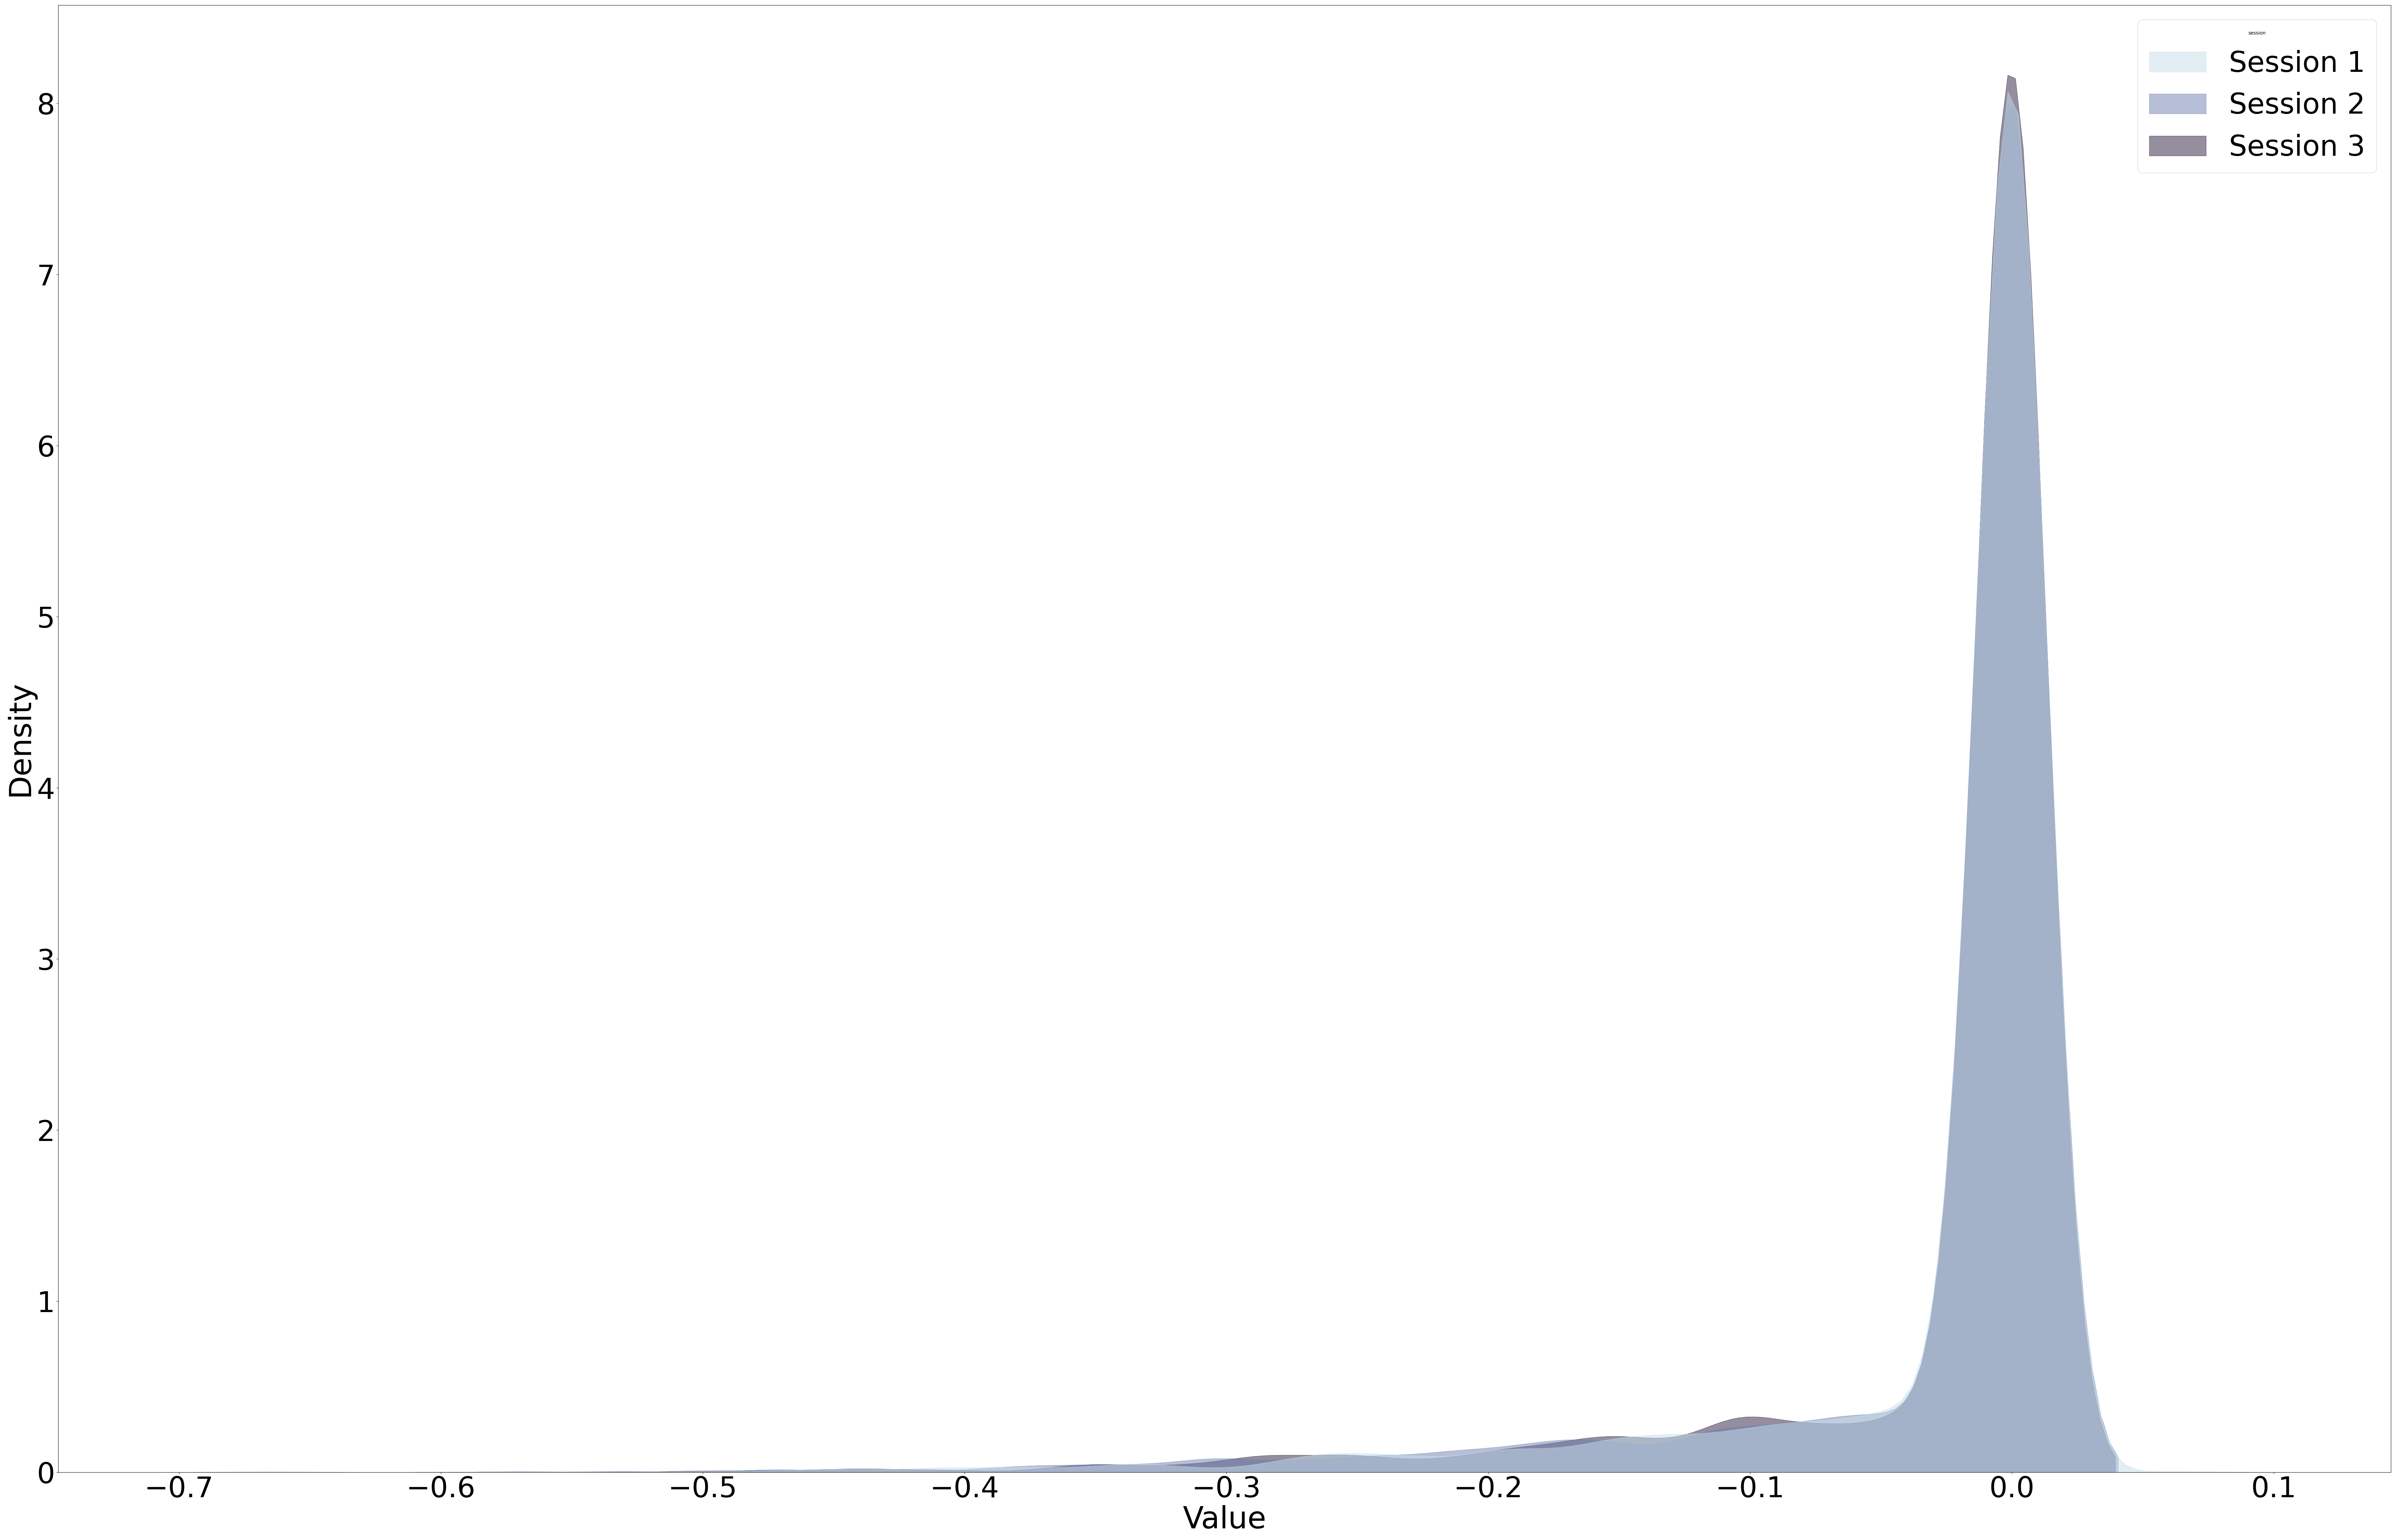

A reportlet does not have to be stored in an image format, it is also possible to incorporate HTML chunks into the overall report. Let us look at an example together. The goal with the next reportlet is to verify whether each session has enough timepoints after censoring to reliably estimate FC. If not, that session needs to be identified and excluded. We use plotly to generate an interactive plot in which hovering on the points tells you the session it corresponds to. The interactivity would not be possible with an image that is why we store the reportlet in HTML format.

In [3]:
import plotly.offline as pyo
import os.path as op

# The literature indicates that less than 5 minutes of fMRI signal after censoring is not enough to reliably estimate functional connectivity.
DURATION_CUT_OFF = 300
# Generate each reportlets
def group_report_censoring(good_timepoints_df, output) -> None:
    """
    Generate a group report about censoring.

    This function generates an HTML report that includes an interactive scatterplot
    showing the fMRI duration after censoring. The scatterplot includes
    error bars for the confidence interval and a red line indicating a duration cutoff.

    Parameters:
    -----------
    good_timepoints_df: pd.Dataframe
        A DataFrame containing information the fMRI duration after censoring.
    output : str
        Path to the output directory
    """
    filenames = good_timepoints_df["filename"]
    durations = good_timepoints_df["duration"]

    # Constructing the data for the plot
    # Add jitter to x values
    jitter = 0.2  # adjust this value to change the amount of jitter
    x_values = [1 + np.random.uniform(-jitter, jitter) for _ in range(len(durations))]
    data = [
        {
            "x": x_values,
            "y": durations,
            "text": filenames,
            "mode": "markers",
            "type": "scatter",
            "hoverinfo": "text",
            "marker": {"opacity": 0.5},
        }
    ]

    # Adding a red line at 5 minutes
    red_line = {
        "type": "line",
        "x0": 0,
        "y0": DURATION_CUT_OFF,
        "x1": 1.5,
        "y1": DURATION_CUT_OFF,
        "line": {"color": "red", "width": 3, "dash": "dashdot"},
    }

    # Layout settings
    layout = {
        "hovermode": "closest",
        "title": "Duration of fMRI signal after censoring",
        "yaxis": {"title": "Duration [s]"},
        "xaxis": {"showticklabels": False, "range": [0.5, 1.5]},
        "shapes": [red_line],
        "width": 600,
        "height": 600,
        "font": {"size": 16},
        "annotations": [
            {
                "x": 0.8,
                "y": DURATION_CUT_OFF - DURATION_CUT_OFF / 55,
                "xref": "x",
                "yref": "y",
                "text": f"QC cutoff of {DURATION_CUT_OFF/60} min",
                "showarrow": False,
                "font": {"color": "red"},
            }
        ],
    }

    fig = {"data": data, "layout": layout}

    # Save the plot as an HTML file
    pyo.plot(
        fig,
        filename=op.join(output, "reportlets", "group_desc-censoring_bold.html"),
        auto_open=False,
    )
group_report_censoring(good_timepoints_df, output)

The plot about censoring looks as follows

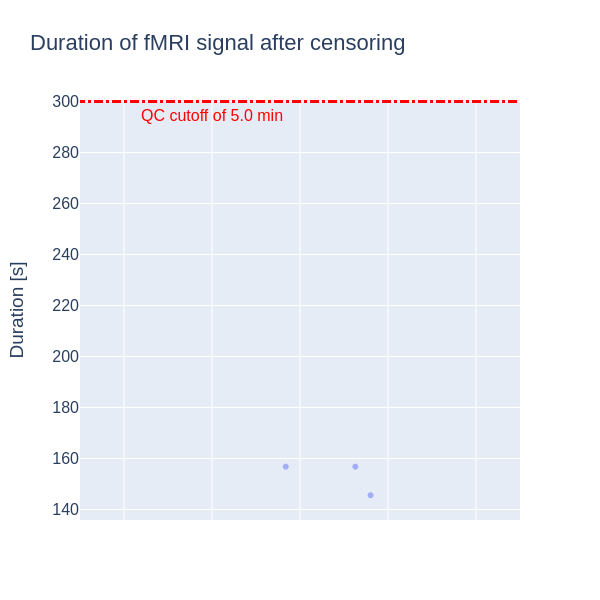

## Assembler

Now that we generated two reportlets, one saved in SVG format and one saved in HTML format, let's combine them into a visual report.
What makes nireports powerful and easy-to-use is that to assemble a visual report all you need is to define a configuration file. Here is the configuration file for this project. Let's dissect it.

```yaml
package: funconn
sections:
- name: Group report 
  reportlets:
  - bids: {desc: fcdist, suffix: bold}
    caption: Density distributions of within-session FC strengths. The FC distribution from each session are overlaid.
    subtitle: Functional connectivity density distributions.
    style:
      max-width: 600px
  - bids:
      desc: censoring
      extension: [.html]
      suffix: bold
    caption: |
      fMRI duration after censoring computed as the number of good timepoints multiplied by the repetition time (TR). 
      The red line corresponds to the QC cutoff of 5 minutes (300 seconds). Less than 5 minutes of fMRI is not enough to 
      reliably estimate connectivity.
    subtitle: Report about censoring.
```

A visual report is a collection of reportlets in a particular order.

Those visualizations are organized into sections. Each section has a title encoded under name and a list of reportlets
```yaml
package: funconn
sections:
- name: Group report 
  reportlets:
```

Each reportlet is defined by a visualization, a title and a caption explaining the reportlet. The corresponding visualization is found by passing a bids filter to PyBIDS.
```yaml
  bids: {desc: fcdist, suffix: bold}
```
In this example we are searching for an image that has bold as suffix (that is ends with `_bold.svg`) and the value associated with desc is fcdist (that is the filename contains `desc-fcdist`). The next two lines define the caption and title of the reportlet

```yaml
caption: Density distributions of within-session FC strengths. The FC distribution from each session are overlaid.
subtitle: Functional connectivity density distributions
```

Similarly, the rest of the configuration file defines the parameters to integrate the HTML snippet we generated earlier into the visual report.

```yaml
- bids:
      desc: censoring
      extension: [.html]
      suffix: bold
    caption: |
      fMRI duration after censoring computed as the number of good timepoints multiplied by the repetition time (TR). 
      The red line corresponds to the QC cutoff of 5 minutes (300 seconds). Less than 5 minutes of fMRI is not enough to 
      reliably estimate connectivity.
    subtitle: Report about censoring.
```


Having this configuration file defined, it is now easy to generate the visual report. This works by instantiating a Report object. You have to pass the path to the configuration file to `bootstrap_file`, `out_filename` contains the filename under which you want to save the visual report, `out_dir` corresponds to where to store the output, `run_uuid`is useful to uniquely identify a run.    

In [4]:
from nireports.assembler.report import Report
from time import strftime
from uuid import uuid4

run_uuid = "{}_{}".format(strftime("%Y%m%d-%H%M%S"), uuid4())
robj = Report(
    out_dir=output,
    run_uuid=run_uuid,
    out_filename="group_report.html",
    bootstrap_file=op.join("data", "reports-spec.yml"),
)
robj.generate_report()


0

You can now open the HTML visual report in a web browser

![Screenshot 2024-05-17 at 21-02-57 Visual report generated by NiReports.png](<attachment:Screenshot 2024-05-17 at 21-02-57 Visual report generated by NiReports.png>)
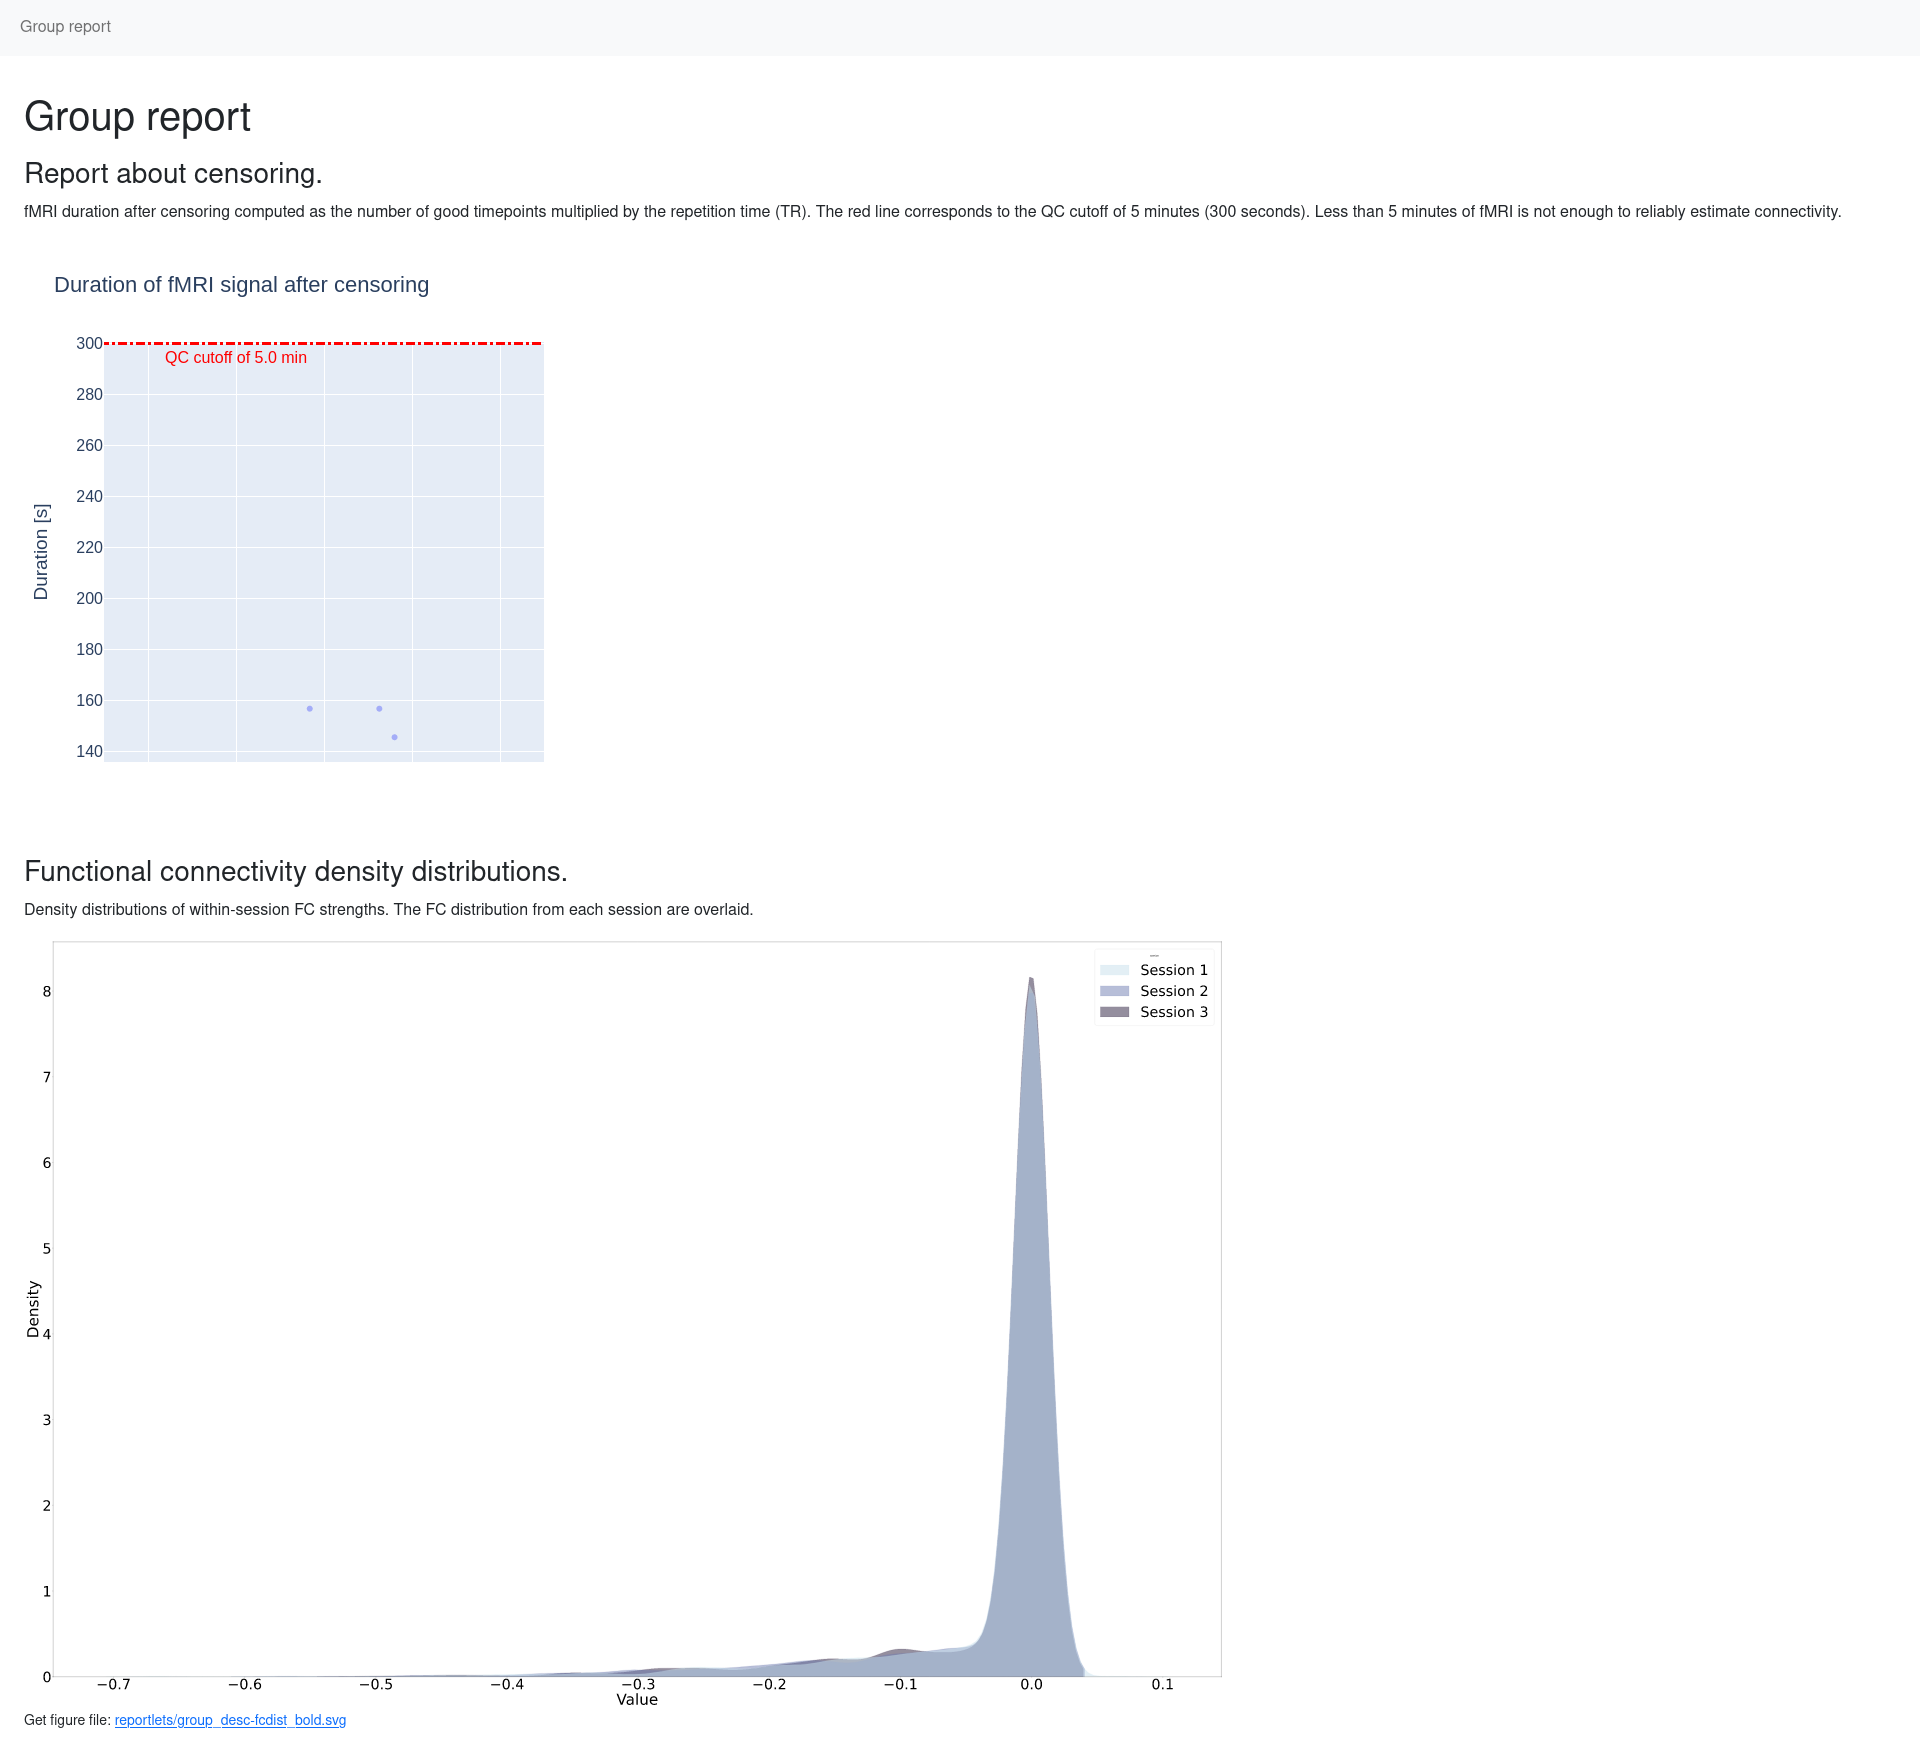